In [1]:
import asyncio
import os
import json
from typing import TypedDict, Annotated, List
from functools import partial
import contextlib

from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

# 시각화를 위한 라이브러리
from langchain_teddynote.graphs import visualize_graph

# MCP-Adapter 관련 라이브러리 (시각화에는 실제 연결 불필요)
# from mcp import ClientSession, StdioServerParameters
# from mcp.client.stdio import stdio_client
# from langchain_mcp_adapters.tools import load_mcp_tools

# .env 파일에서 환경 변수 로드
load_dotenv()

print("라이브러리 import 완료!")


라이브러리 import 완료!


In [2]:
# medical_agent.py에서 가져온 상태 정의
class AgentState(TypedDict):
    """Agent의 상태를 정의합니다. LangGraph의 모든 노드는 이 상태를 공유하고 수정합니다."""
    # 대화의 흐름을 추적하기 위한 메시지 리스트
    messages: Annotated[List[BaseMessage], lambda x, y: x + y]

print("상태 정의 완료!")


상태 정의 완료!


In [3]:
# --- LangGraph 노드(Node) 정의 ---

# 한글 → 영어 번역 노드
async def translate_to_english(state: AgentState, translator_model):
    """한글 사용자 입력을 영어로 번역합니다."""
    messages = state["messages"]
    last_human_message = None
    
    # 마지막 사용자 메시지 찾기
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            last_human_message = message
            break
    
    if last_human_message is None:
        return {"messages": []}
    
    # 번역 프롬프트
    translation_prompt = f"""
        다음 한글 텍스트를 의료/과학 논문 검색에 적합한 영어로 번역해주세요. 
        의학 용어는 정확한 영어 용어로 번역하고, 검색 키워드로 적합하도록 간결하게 번역해주세요.

        한글 텍스트: {last_human_message.content}

        영어 번역:"""

    print("🔄 한글 → 영어 번역 중...")
    print(f"원문: {last_human_message.content}")
    
    response = await translator_model.ainvoke([HumanMessage(content=translation_prompt)])
    translated_text = response.content.strip()
    
    print(f"번역: {translated_text}")
    
    # 번역된 내용으로 새로운 HumanMessage 생성
    translated_message = HumanMessage(content=translated_text)
    
    # 기존 메시지들을 유지하되, 마지막 HumanMessage만 번역된 것으로 교체
    new_messages = []
    for message in messages[:-1]:  # 마지막 메시지 제외
        new_messages.append(message)
    new_messages.append(translated_message)
    
    return {"messages": new_messages}

# Agent 역할을 하는 노드: 모델을 비동기적으로 호출합니다.
async def call_model(state: AgentState, model):
    """LLM을 호출하여 응답 또는 도구 호출을 생성합니다."""
    messages = state["messages"]
    # .ainvoke()는 AIMessage 객체를 반환합니다.
    response = await model.ainvoke(messages)
    return {"messages": [response]}

# 한글 직접 응답 노드
async def korean_direct_answer(state: AgentState, translator_model):
    """도구 사용 없이 바로 한글로 답변합니다."""
    messages = state["messages"]
    
    # 마지막 영어 번역된 사용자 질문 찾기
    last_human_message = None
    for message in reversed(messages):
        if isinstance(message, HumanMessage):
            last_human_message = message
            break
    
    if last_human_message is None:
        return {"messages": []}
    
    # 한글 직접 응답 프롬프트
    korean_prompt = f"""
        다음 질문에 대해 한국어로 직접 답변해주세요. 논문 검색이 필요하지 않은 일반적인 질문이므로 당신의 지식을 바탕으로 정확하고 자세한 답변을 제공해주세요.

        질문: {last_human_message.content}

        한국어 답변:"""

    print("🔄 한글로 직접 답변 생성 중...")
    
    response = await translator_model.ainvoke([HumanMessage(content=korean_prompt)])
    korean_answer = response.content.strip()
    
    print(f"한글 답변 완료!")
    
    # 한글 답변으로 새로운 AIMessage 생성
    korean_message = AIMessage(content=korean_answer)
    
    return {"messages": [korean_message]}

# 영어 → 한글 번역 노드 (도구 사용 후)
async def translate_to_korean(state: AgentState, translator_model):
    """영어 도구 결과를 한글로 번역합니다."""
    messages = state["messages"]
    
    # 마지막 도구 실행 결과 찾기
    last_tool_message = None
    for message in reversed(messages):
        if isinstance(message, ToolMessage):
            last_tool_message = message
            break
    
    if last_tool_message is None or not last_tool_message.content:
        return {"messages": []}
    
    # 번역 프롬프트 - 논문 정보 보존
    translation_prompt = f"""
        다음 영어 논문 검색 결과를 한국어로 번역해주세요. 다음 규칙을 따라주세요:

        번역 규칙:
        1. PMID, DOI 등의 식별자: 그대로 유지
        2. Title (제목): 영어 그대로 유지
        3. Authors (저자): 영어 이름 그대로 유지 
        4. Journal (저널명): 영어 그대로 유지
        5. Publication Date: 영어 그대로 유지
        6. Abstract (초록): 한국어로 상세히 번역
        7. 기타 메타데이터: 적절히 번역하되 정보 손실 없이 보존

        논문 검색 결과:
        {last_tool_message.content}

        한국어 번역:"""

    print("🔄 논문 검색 결과를 한글로 번역 중...")
    
    response = await translator_model.ainvoke([HumanMessage(content=translation_prompt)])
    translated_text = response.content.strip()
    
    print(f"최종 번역 완료!")
    
    # 번역된 내용으로 새로운 AIMessage 생성
    translated_message = AIMessage(content=translated_text)
    
    return {"messages": [translated_message]}

print("노드 함수 정의 완료!")


노드 함수 정의 완료!


In [4]:
# medical_agent.py에서 가져온 조건부 엣지 로직
def should_continue_or_answer_medical(state: AgentState) -> str:
    """
    Medical 워크플로우의 조건부 분기 로직
    - 도구 호출이 있으면: "continue" (action 노드로 이동)
    - 도구 호출이 없으면: "direct_answer" (한글 직접 답변 후 종료)
    """
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "continue"
    return "direct_answer"

def after_action_medical(state: AgentState) -> str:
    """Medical 워크플로우의 action 후 분기 로직"""
    messages = state["messages"]
    tool_call_count = sum(1 for msg in messages if isinstance(msg, AIMessage) and msg.tool_calls)
    
    last_tool_message = next(
        (msg for msg in reversed(messages) if isinstance(msg, ToolMessage)), 
        None
    )
    
    # 도구 호출이 너무 많거나 충분한 결과가 있으면 번역으로 이동
    if tool_call_count > 2 or (last_tool_message and len(last_tool_message.content) > 200):
        return "translate"
    
    return "agent"

def should_continue_or_answer_general(state: AgentState) -> str:
    """General 워크플로우의 조건부 분기 로직"""
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "continue"
    return "direct_answer"

print("조건부 엣지 로직 정의 완료!")


조건부 엣지 로직 정의 완료!


In [5]:
# medical_agent.py에서 가져온 도구들과 모델 설정
from langchain_core.tools import tool

# 시각화를 위한 더미 도구 생성 (medical_agent.py의 실제 MCP 도구들과 유사하게)
@tool
def search_papers(query: str, source: str = "pubmed", max_results: int = 10) -> str:
    """Paper Search MCP를 통해 다양한 데이터베이스에서 논문을 검색합니다."""
    return f"Paper Search MCP 결과 ({source}): {query}"

@tool
def search_pubmed_direct(query: str, max_results: int = 10) -> str:
    """PubMed MCP Server를 통해 직접 PubMed에서 논문을 검색합니다."""
    return f"PubMed MCP Server 결과: {query}"

@tool
def download_paper_content(paper_id: str, source: str = "pubmed") -> str:
    """논문의 전문 내용을 다운로드합니다."""
    return f"논문 다운로드 완료: {paper_id} from {source}"

@tool
def extract_paper_metadata(paper_url: str) -> str:
    """논문의 메타데이터를 추출합니다."""
    return f"메타데이터 추출 완료: {paper_url}"

# 더미 도구 리스트
tools = [search_papers, search_pubmed_direct, download_paper_content, extract_paper_metadata]

# 모델 설정
try:
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o")
    translator_model = ChatOpenAI(temperature=0, model="gpt-4o")
    model_with_tools = model.bind_tools(tools)
    print("실제 OpenAI 모델 설정 완료!")
    print("번역 전용 모델 설정 완료!")
except Exception as e:
    print(f"OpenAI 모델 설정 실패 (API 키 문제일 수 있음): {e}")
    print("더미 모델로 진행...")
    
    class DummyModel:
        def bind_tools(self, tools):
            return self
        async def ainvoke(self, messages):
            from langchain_core.messages import AIMessage
            return AIMessage(content="더미 응답")
    
    model_with_tools = DummyModel()
    translator_model = DummyModel()

print("도구 및 모델 설정 완료!")


실제 OpenAI 모델 설정 완료!
번역 전용 모델 설정 완료!
도구 및 모델 설정 완료!


In [6]:
# medical_agent.py에서 가져온 의료 워크플로우 구조
from langgraph.prebuilt import ToolNode

# WorkflowFactory 구현 (medical_agent.py 스타일)
class WorkflowFactory:
    @staticmethod
    def create_medical_workflow(tools, model, translator_model):
        """의료 논문 검색 워크플로우 생성 (medical_agent.py의 실제 구조)"""
        workflow = StateGraph(AgentState)
        
        # safe_tool_node 구현 (안전한 도구 실행)
        async def safe_tool_node(state):
            try:
                tool_node = ToolNode(tools)
                result = await tool_node.ainvoke(state)
                return result
            except Exception as e:
                print(f"도구 실행 오류: {e}")
                from langchain_core.messages import ToolMessage
                return {"messages": [ToolMessage(content=f"오류: {str(e)}", tool_call_id="error")]}
        
        # 노드 정의 (medical_agent.py와 동일한 구조)
        workflow.add_node("translate_to_english", partial(translate_to_english, translator_model=translator_model))
        workflow.add_node("agent", partial(call_model, model=model))
        workflow.add_node("action", safe_tool_node)
        workflow.add_node("translate_to_korean", partial(translate_to_korean, translator_model=translator_model))
        workflow.add_node("direct_answer", partial(korean_direct_answer, translator_model=translator_model))
        
        # 엣지 정의 (medical_agent.py와 동일한 흐름)
        workflow.set_entry_point("translate_to_english")
        workflow.add_edge("translate_to_english", "agent")
        workflow.add_conditional_edges(
            "agent", 
            should_continue_or_answer_medical, 
            {
                "continue": "action", 
                "direct_answer": "direct_answer"
            }
        )
        workflow.add_conditional_edges(
            "action",
            after_action_medical,
            {
                "agent": "agent",
                "translate": "translate_to_korean"
            }
        )
        workflow.add_edge("translate_to_korean", END)
        workflow.add_edge("direct_answer", END)
        
        return workflow

# Medical Workflow 생성
medical_workflow = WorkflowFactory.create_medical_workflow(tools, model_with_tools, translator_model)

print("의료 논문 검색 워크플로우 생성 완료!")


의료 논문 검색 워크플로우 생성 완료!


의료 논문 검색 워크플로우 시각화를 생성합니다...


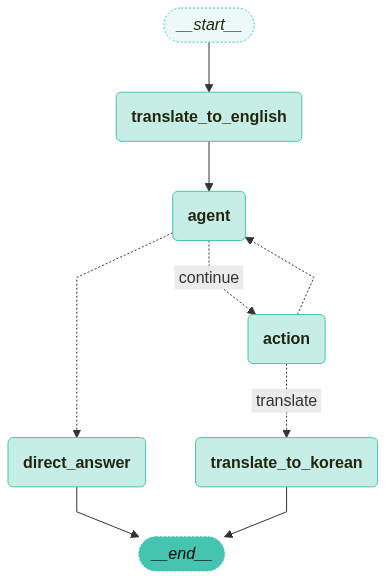

In [7]:
# medical_agent.py 기반 의료 워크플로우 시각화
# 의료 워크플로우 그래프 컴파일
medical_app = medical_workflow.compile()

# 그래프 시각화
print("의료 논문 검색 워크플로우 시각화를 생성합니다...")
visualize_graph(medical_app)


In [8]:
# medical_agent.py의 General 워크플로우 구현
class WorkflowFactory:
    @staticmethod
    def create_general_workflow(tools, model, translator_model):
        """일반 질문 워크플로우 생성 (medical_agent.py의 실제 구조)"""
        workflow = StateGraph(AgentState)
        
        # korean_agent 구현 (한국어 에이전트)
        async def korean_agent(state):
            try:
                messages = state["messages"]
                response = await model.ainvoke(messages)
                return {"messages": [response]}
            except Exception as e:
                print(f"한국어 에이전트 오류: {e}")
                from langchain_core.messages import AIMessage
                return {"messages": [AIMessage(content=f"죄송합니다. 오류가 발생했습니다: {str(e)}")]}
        
        # simple_tool_node 구현 (단순한 도구 실행)
        async def simple_tool_node(state):
            try:
                tool_node = ToolNode(tools)
                result = await tool_node.ainvoke(state)
                return result
            except Exception as e:
                print(f"도구 실행 오류: {e}")
                from langchain_core.messages import ToolMessage
                return {"messages": [ToolMessage(content=f"오류: {str(e)}", tool_call_id="error")]}
        
        # format_korean_response 구현 (한국어 응답 포맷팅)
        async def format_korean_response(state):
            try:
                messages = state["messages"]
                last_tool_message = None
                for message in reversed(messages):
                    if isinstance(message, ToolMessage):
                        last_tool_message = message
                        break
                
                if last_tool_message and last_tool_message.content:
                    # 도구 결과를 한국어로 포맷팅
                    format_prompt = f"""
                    다음 도구 실행 결과를 한국어로 자연스럽게 포맷팅해주세요:
                    
                    {last_tool_message.content}
                    
                    한국어 답변:"""
                    
                    response = await translator_model.ainvoke([HumanMessage(content=format_prompt)])
                    from langchain_core.messages import AIMessage
                    return {"messages": [AIMessage(content=response.content.strip())]}
                else:
                    from langchain_core.messages import AIMessage
                    return {"messages": [AIMessage(content="도구 실행 결과를 받지 못했습니다.")]}
            except Exception as e:
                print(f"응답 포맷팅 오류: {e}")
                from langchain_core.messages import AIMessage
                return {"messages": [AIMessage(content=f"응답 처리 중 오류가 발생했습니다: {str(e)}")]}
        
        # 노드 정의 (General 워크플로우)
        workflow.add_node("korean_agent", korean_agent)
        workflow.add_node("action", simple_tool_node)
        workflow.add_node("format_response", format_korean_response)
        
        # 엣지 정의 (General 워크플로우)
        workflow.set_entry_point("korean_agent")
        workflow.add_conditional_edges(
            "korean_agent", 
            should_continue_or_answer_general, 
            {
                "continue": "action", 
                "direct_answer": END
            }
        )
        workflow.add_edge("action", "format_response")
        workflow.add_edge("format_response", END)
        
        return workflow

# General Workflow 생성
general_workflow = WorkflowFactory.create_general_workflow(tools, model_with_tools, translator_model)

print("일반 질문 워크플로우 생성 완료!")


일반 질문 워크플로우 생성 완료!


일반 질문 워크플로우 시각화를 생성합니다...


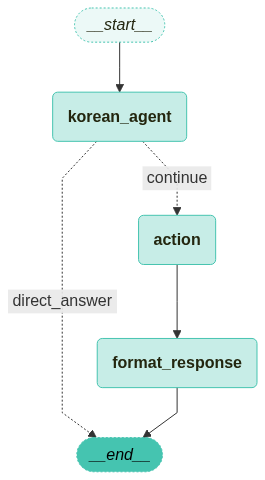

In [9]:
# General 워크플로우 시각화
general_app = general_workflow.compile()

print("일반 질문 워크플로우 시각화를 생성합니다...")
visualize_graph(general_app)
